# Sentiment Analysis for Mental Health

#### ``Data``

https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data



---
### Step 1: Import libraries

In [35]:
# All packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import bigrams
from nltk.util import ngrams
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
!pip install keras-tuner --upgrade
import keras_tuner as kt
from keras_tuner import HyperParameters
import shutil
from tensorflow.keras.models import load_model

import gensim.downloader as api

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

---
# Step 2: Data Loading & Inspection

In [36]:
# connect to google drive, comment out if you don't need this - victoria
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loading

In [37]:
# path to the data - ADJUST IF RUNNING IN NEW ENV! =)
folder_path = '/content/drive/My Drive/Data Science/Courses/DATASCI 207 Introduction to Machine Learning/Final Project/datasci207-final-project/'

# get file_path
file_name = 'data/raw_data.csv'
file_path = f"{folder_path}/{file_name}"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)


### Data Inspection

In [38]:
# name columns
df.rename(columns={'Unnamed: 0': 'unique_id'}, inplace = True)

# Display the DataFrame
df.head()

,unique_id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


---
# Step 3: Exploratory Data Analysis (Before Text Preprocessing)
### Explore Missing Data

Data Shape: Rows = 53043 , Columns = 3

Missing Values by Column:
unique_id      0
statement    362
status         0
dtype: int64

Distribution of 'status' for missing 'statement':
status
Personality disorder    124
Bipolar                 100
Stress                   82
Anxiety                  47
Normal                    8
Suicidal                  1
Name: count, dtype: int64


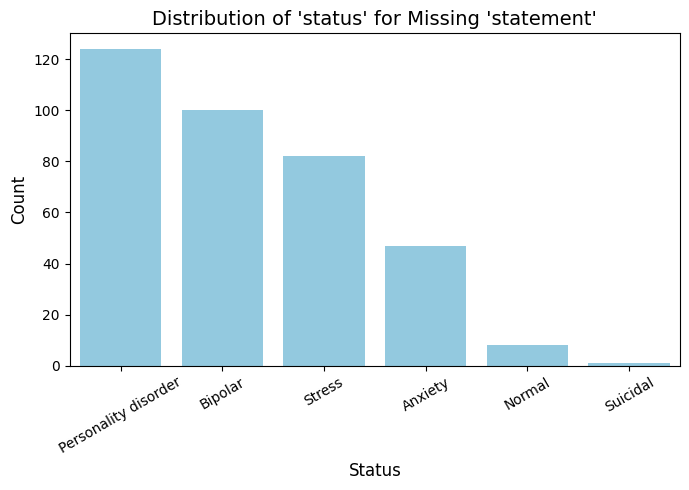

In [39]:
# filter rows where statement column is missing
missing_statement_data = df[df['statement'].isnull()]

# calculate the distribution of status for missing statement rows
status_distribution = missing_statement_data['status'].value_counts()

# print data shape and distribution of status
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nMissing Values by Column:")
print(df.isnull().sum())
print("\nDistribution of 'status' for missing 'statement':")
print(status_distribution)

# plot the distribution
plt.figure(figsize=(7, 5))
sns.barplot(
    x = status_distribution.index,
    y=status_distribution.values,
    color='skyblue'
)

# labels
plt.title("Distribution of 'status' for Missing 'statement'", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()

# display the plot
plt.show()

### Evaluate the Balance of Status (Class Balance)

Data Shape: Rows = 51795 , Columns = 4

Overall Distribution of 'status':
status
Normal                  15511
Depression              15372
Suicidal                10644
Anxiety                  3829
Bipolar                  2777
Stress                   2585
Personality disorder     1077
Name: count, dtype: int64

Percentages of 'status':
status
Normal                  30.0
Depression              30.0
Suicidal                21.0
Anxiety                  7.0
Bipolar                  5.0
Stress                   5.0
Personality disorder     2.0
Name: count, dtype: float64


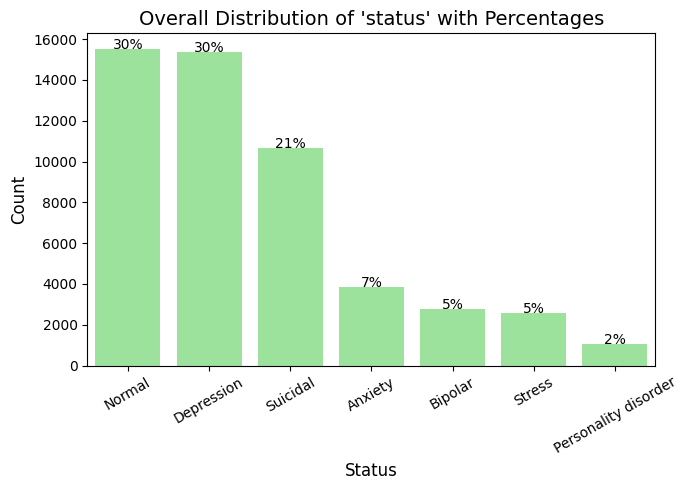

In [40]:
# remove missing statements
df = df[df['statement'].notnull()]

# Add statement length field
df['statement_len'] = df['statement'].apply(lambda x: len(x.split(' ')))

# Remove statements with less than 2 words
df = df[df['statement_len'] > 2].reset_index(drop = True)

# calculate the overall distribution of status and percentages
status_distribution_overall = df['status'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of 'status':")
print(status_distribution_overall)
print("\nPercentages of 'status':")
print(status_percentages.round())

# plot the overall status distribution with percentages
plt.figure(figsize=(7, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='lightgreen')

# titles and labels
plt.title("Overall Distribution of 'status' with Percentages", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()

---
# Step 4: Performing Text Preprocessing

In [41]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# additional domain-specific stopwords
domain_stopwords = set([
    "mental",
    "health",
    "condition",
    "like", "feel",
    "know",
    "year",
    "old",
    "even",
    "though",
    "ive"
])

# Helper function to remove duplicates while preserving token order
def remove_duplicates_preserve_order(tokens):
    seen = set()
    return [token for token in tokens if not (token in seen or seen.add(token))]

def preprocess_text(text):
    # Remove URLs (including .org, .edu, .gov, and others)
    text = re.sub(
        r'http[s]?://\S+|www\.\S+|\S+\.(com|org|edu|gov|net|io|co)\S*',
        '',
        text
    )

    # Convert to lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Removes special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)

    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove short words and stopwords
    tokens = [word for word in tokens if len(word) > 2 and word not in stopwords.words('english') and word not in domain_stopwords]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [42]:
# get processed_file_path
processed_file_name = 'data/processed_data.pkl'
processed_file_path = f"{folder_path}/{processed_file_name}"

# Check if the processed file exists
if os.path.exists(processed_file_path):
    # Load the processed data
    df = pd.read_pickle(processed_file_path)
    print("Processed data loaded from file.")
else:
    # Perform preprocessing
    df['processed_text'] = df['statement'].dropna().apply(preprocess_text)

    # Save the processed data to a file
    df.to_pickle(processed_file_path)
    print("Processed data saved to file.")

df.head()

Processed data loaded from file.


,unique_id,statement,status,statement_len,processed_text
0,0,oh my gosh,Anxiety,3,[gosh]
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,"[trouble, sleeping, confused, mind, restless, ..."
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,"[wrong, back, dear, forward, doubt, stay, rest..."
3,3,I've shifted my focus to something else but I'...,Anxiety,11,"[shifted, focus, something, else, still, worried]"
4,4,"I'm restless and restless, it's been a month n...",Anxiety,14,"[restless, restless, month, boy, mean]"


---
# Step 5: Exploratory Data Analysis (After Text Preprocessing)

### Most Useful Common Words per Category

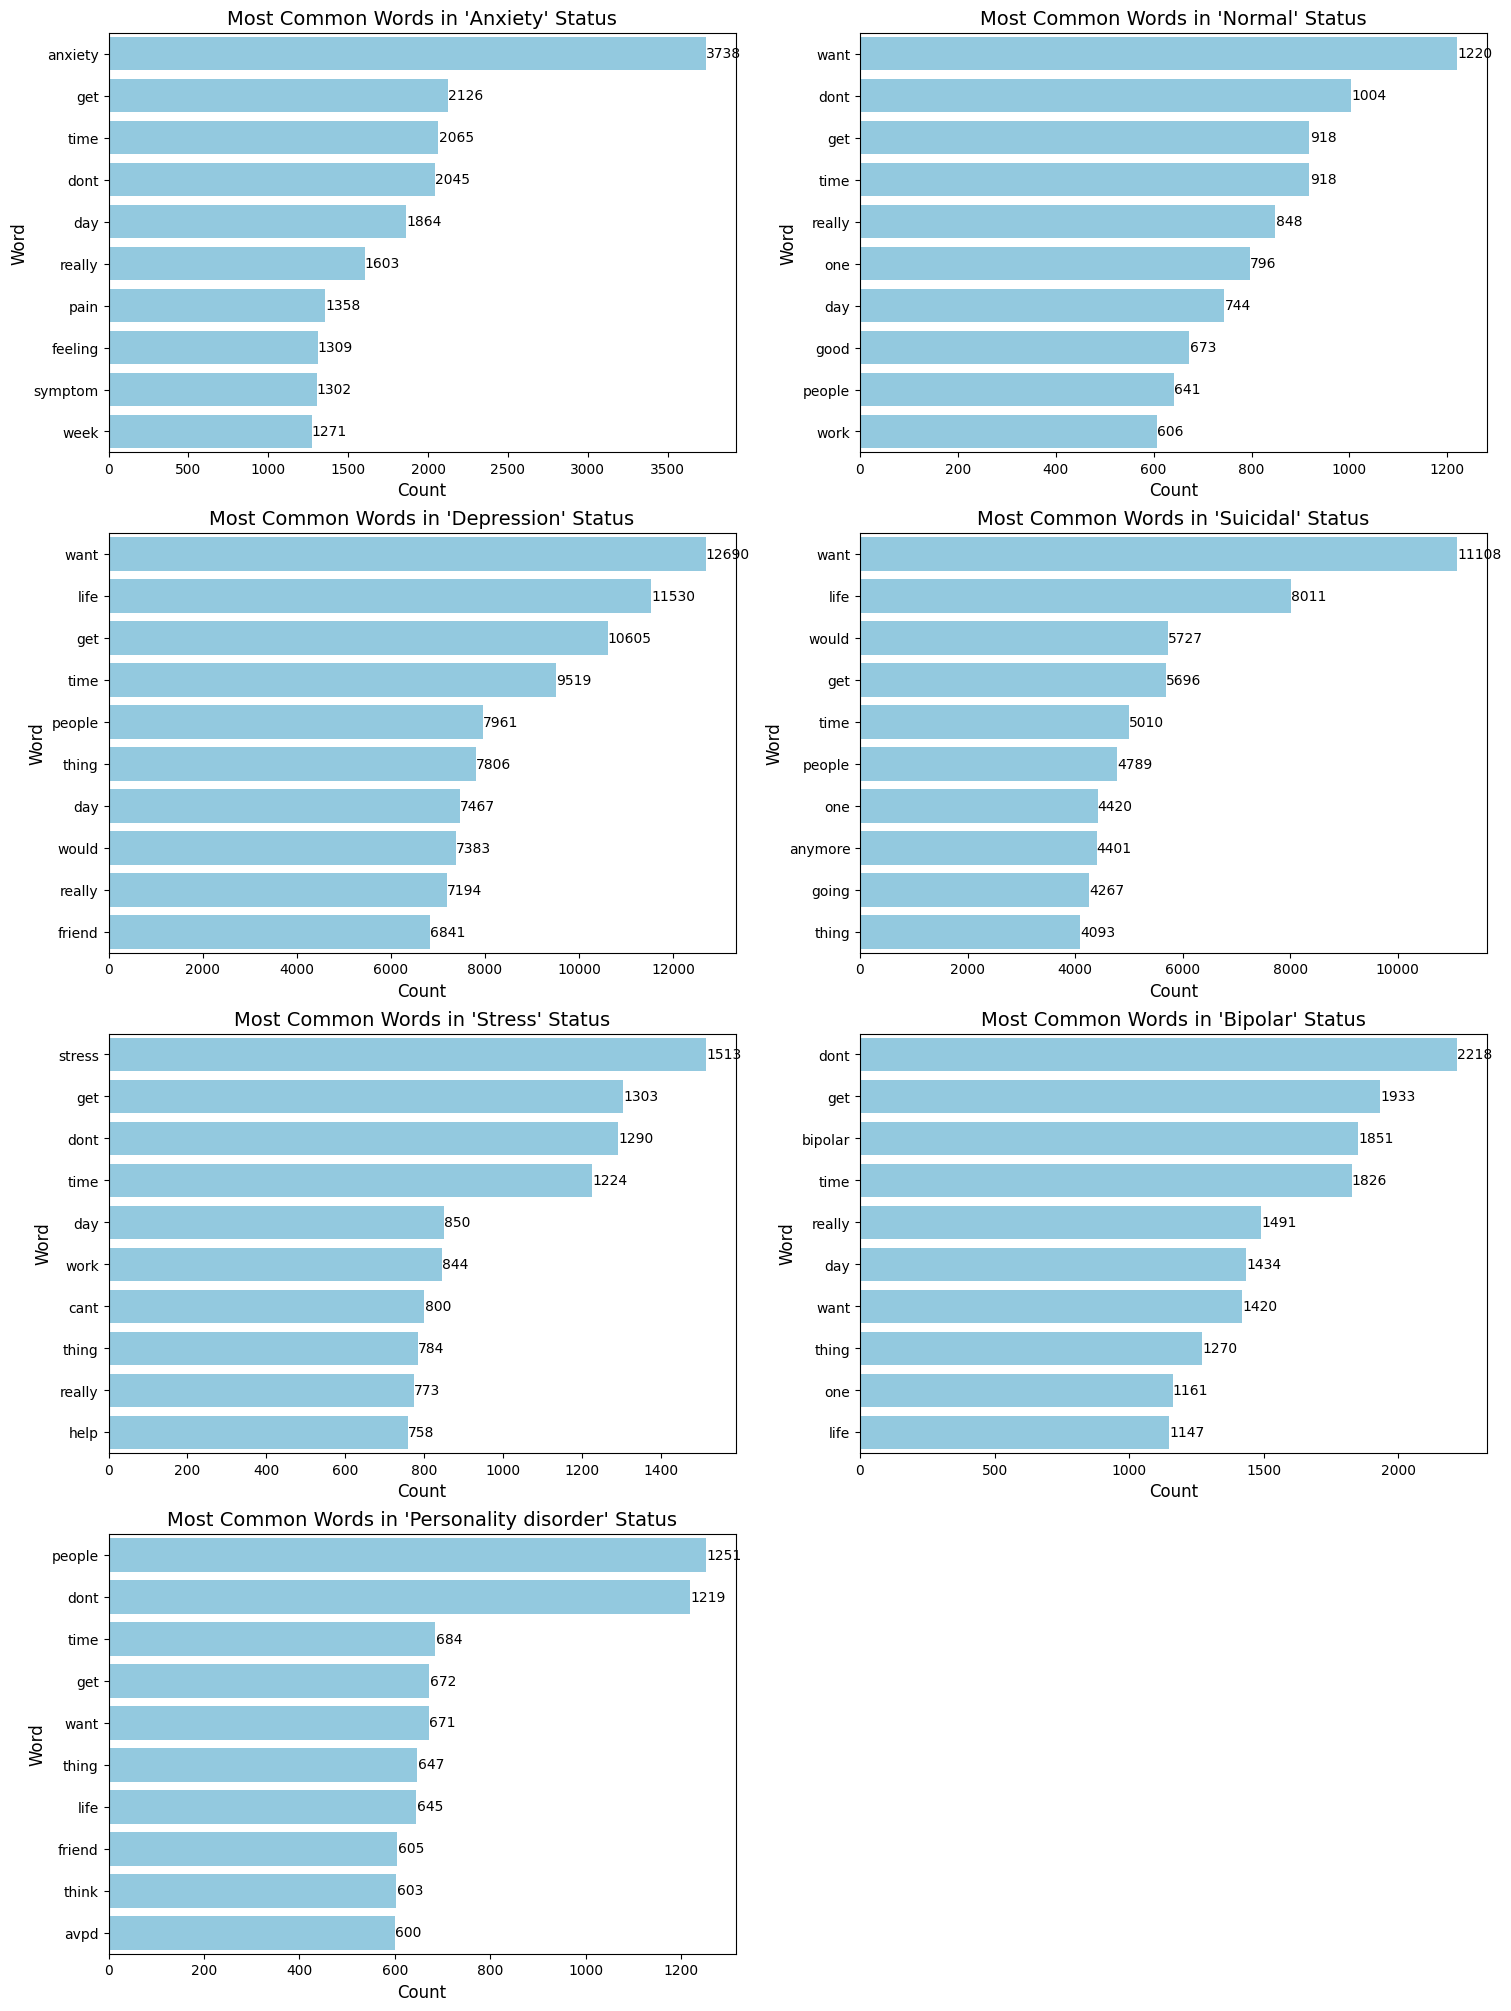

In [43]:
# Collect unique hits on status
status_categories = df['status'].unique()

# Function to get most common words for a given status
def get_common_words(df, status, n=10):
    # Filter for specific status and flatten preprocessed words
    filtered_text = df[df['status'] == status]['processed_text']
    words = [word for text in filtered_text for word in text]
    # Get most common words
    return Counter(words).most_common(n)

# Prepare for multiple plots because each status will have its own plot
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

# Flatten axes to make iteration simpler
axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common words for the current status
    most_common_words = get_common_words(df, status, n=10)
    most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

    sns.barplot(data=most_common_df, x='Count', y='Word', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Words in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Word", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

# Remove empty subplots if any
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common Bi-Gram per Category

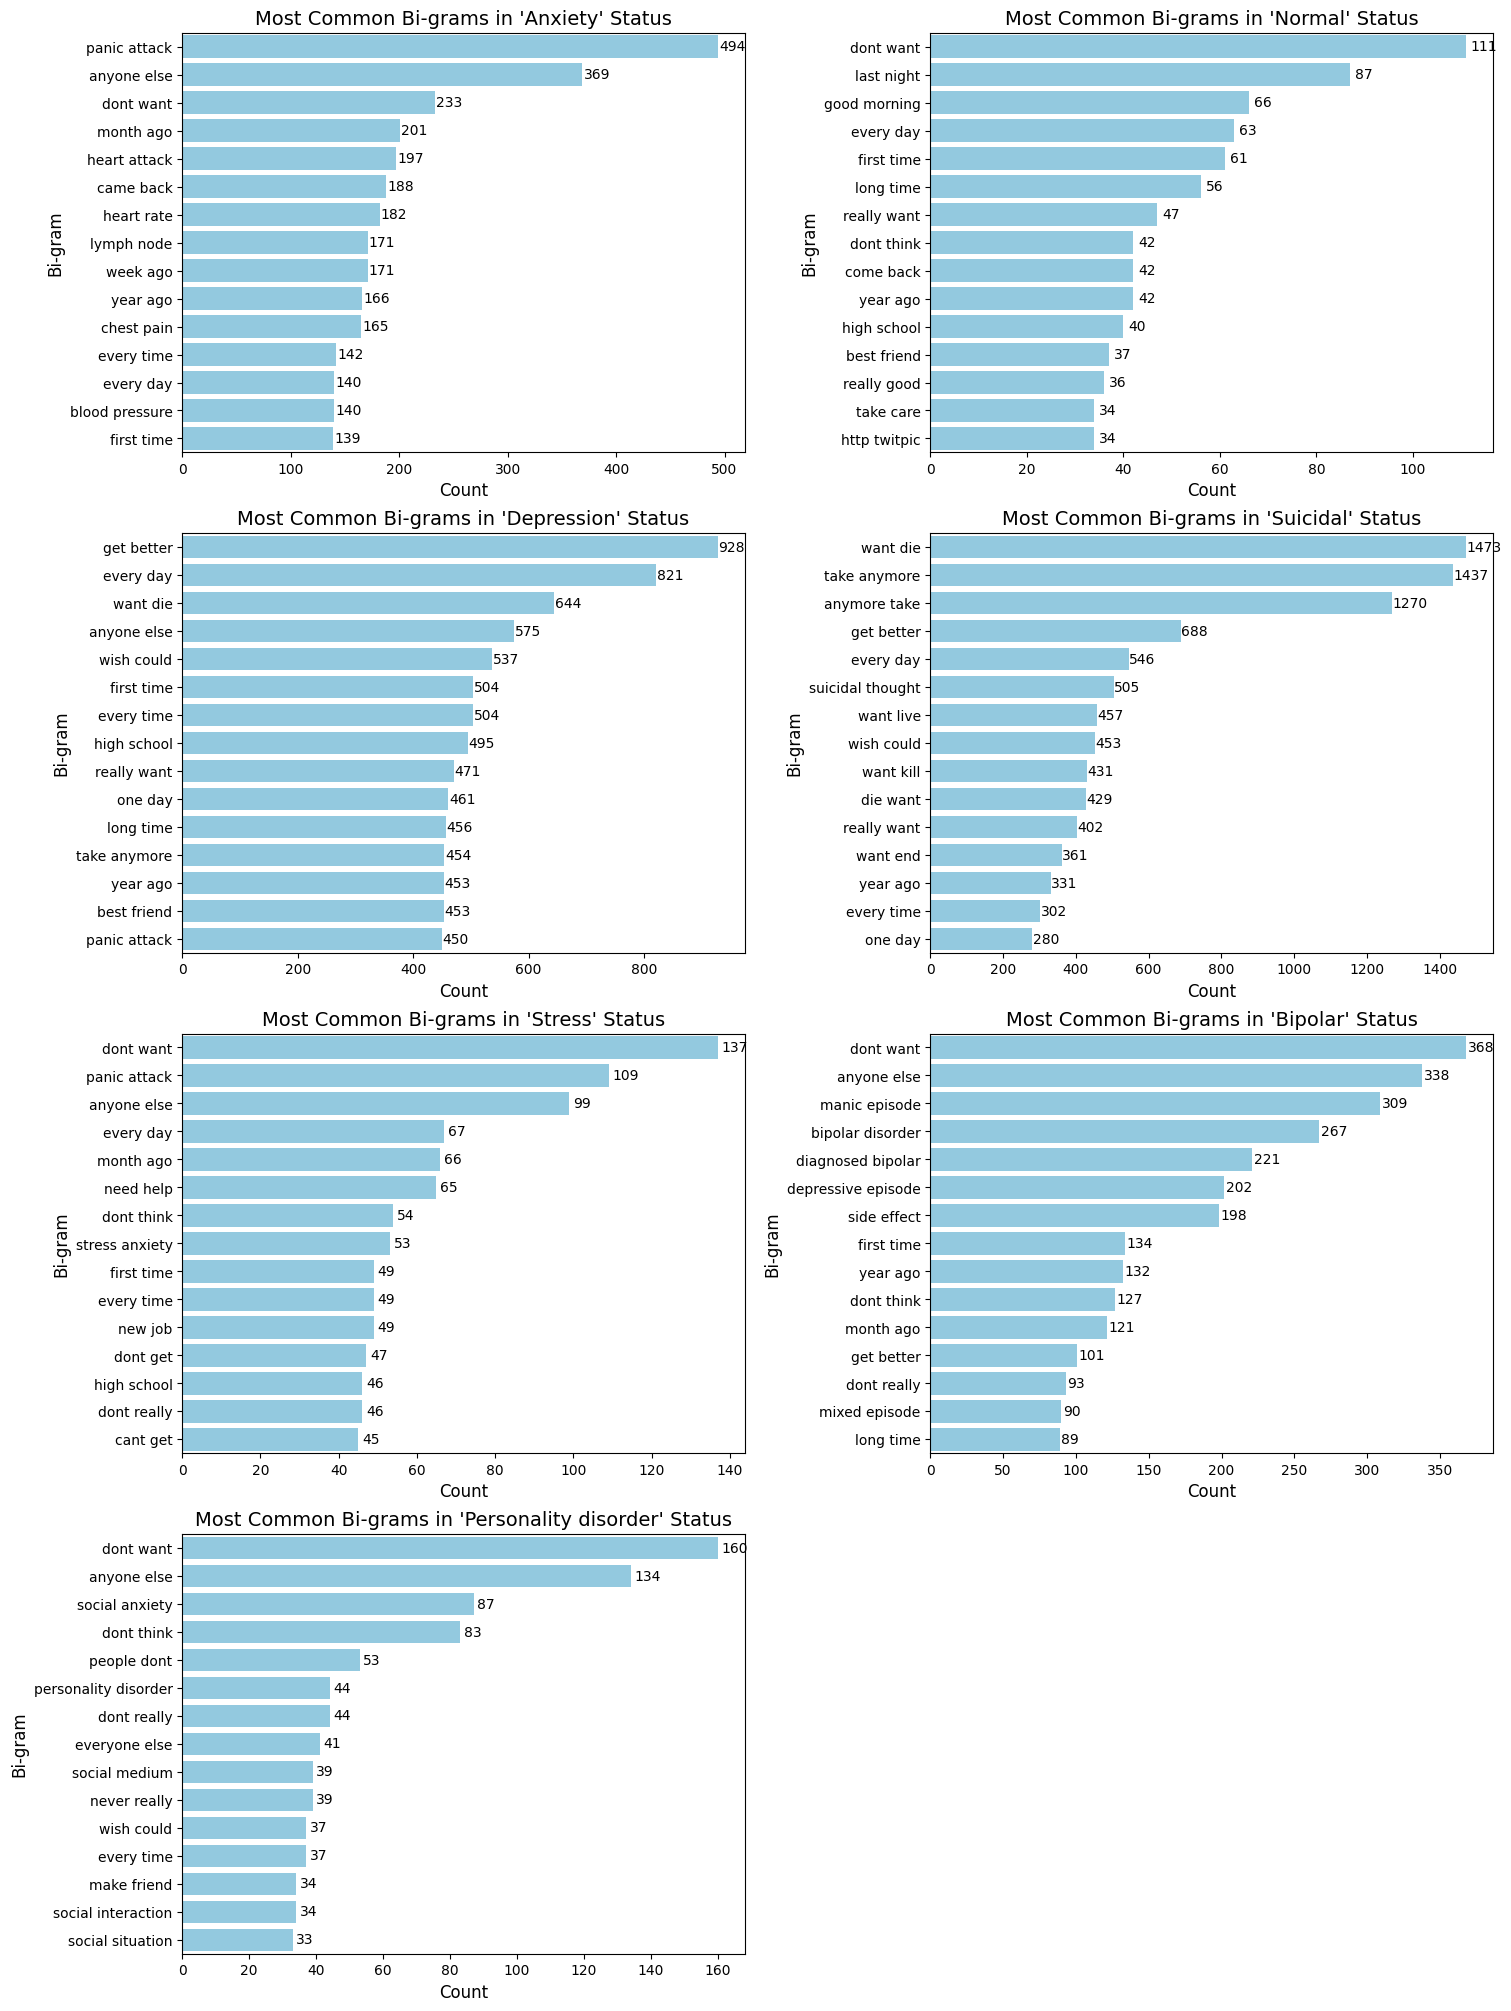

In [44]:
# Function to get most common bi-grams for a given status
def get_common_bigrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['status'] == status]['processed_text']
    # Flatten tokens and generate bi-grams
    bigram_list = [bigram for text in filtered_text for bigram in bigrams(text)]
    # Get most common bi-grams
    return Counter(bigram_list).most_common(n)

status_categories = df['status'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols  # Calculate number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common bi-grams for the current status
    most_common_bigrams = get_common_bigrams(df, status, n=15)
    # Convert bi-grams to a readable format (e.g., "word1 word2")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2}", count) for (w1, w2), count in most_common_bigrams],
        columns=['Bi-gram', 'Count']
    )

    # Plot the most common bi-grams
    sns.barplot(data=most_common_df, x='Count', y='Bi-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Bi-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Bi-gram", fontsize=12)

    # Add the count on the bars
    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common N-Gram per Category

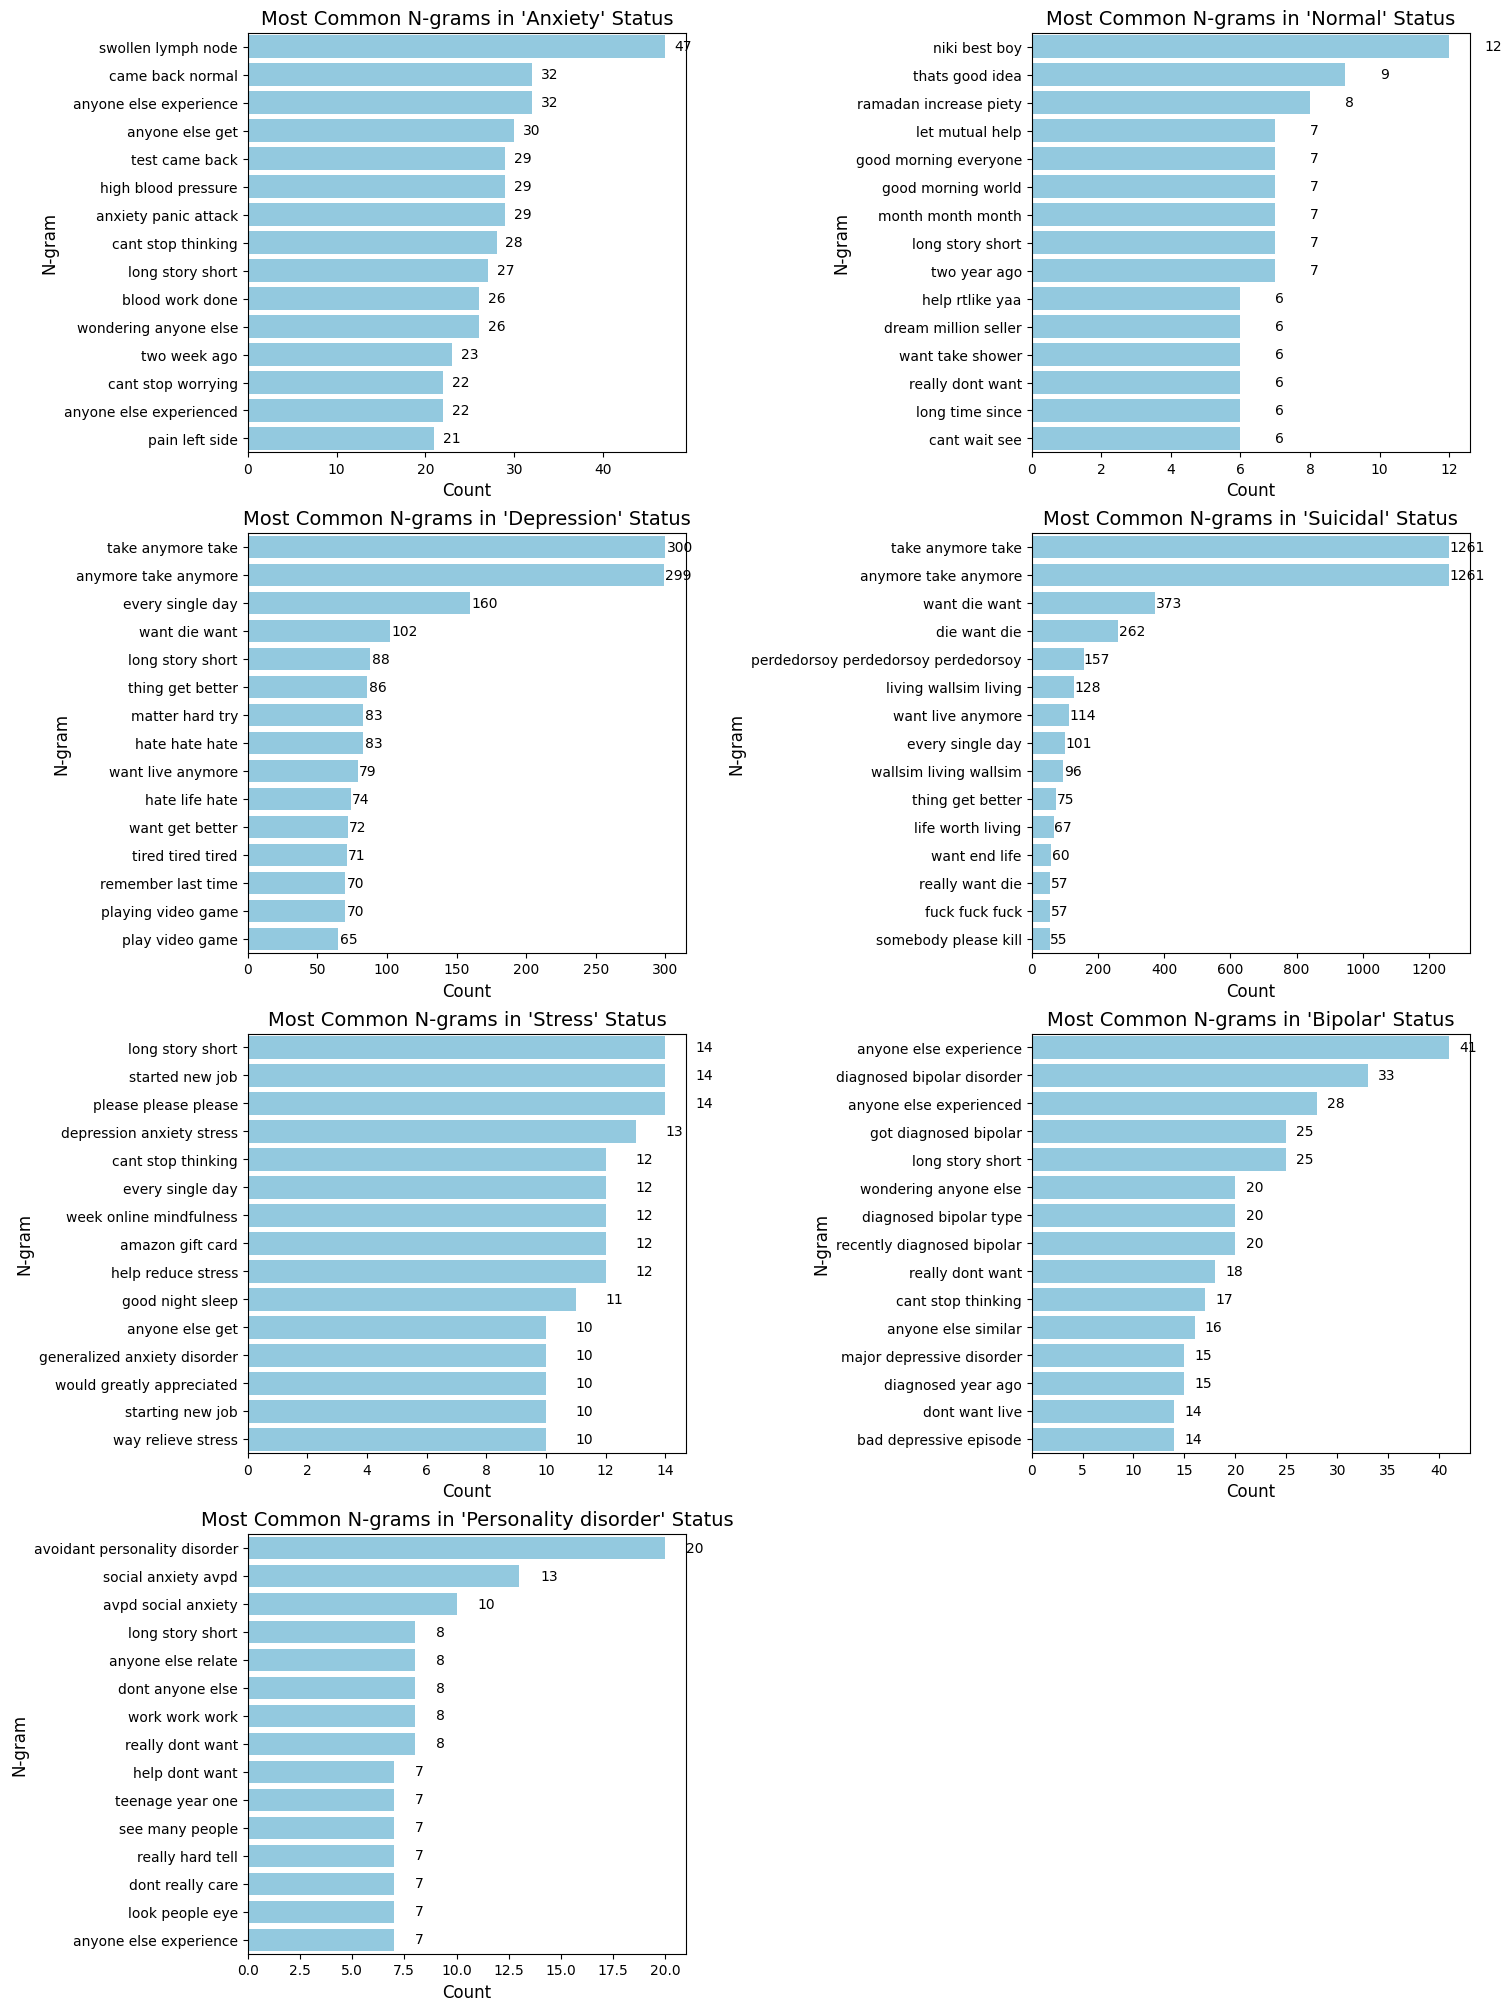

In [45]:
# Function to get most common N-grams for a given status
def get_common_ngrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['status'] == status]['processed_text']
    # Flatten tokens and filter out unwanted tokens
    cleaned_text = [
        [token for token in text if not re.match(r'http|www|com|org|edu|gov|net|io|co', token)]
        for text in filtered_text
    ]

    # Flatten tokens and generate N-grams
    ngram_list = [ngram for text in cleaned_text for ngram in ngrams(text, 3)]
    # Get most common N-grams
    return Counter(ngram_list).most_common(n)


status_categories = df['status'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)


axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common N-grams for the current status
    most_common_ngrams = get_common_ngrams(df, status, n=15)
    # Convert N-grams to a readable format (e.g., "word1 word2 word3")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2} {w3}", count) for (w1, w2, w3), count in most_common_ngrams],
        columns=['N-gram', 'Count']
    )

    # Plot the most common N-grams
    sns.barplot(data=most_common_df, x='Count', y='N-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common N-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("N-gram", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

---
# Step 6: Grouping Status Into New Class Labels

In [46]:
# Define the mapping for status groups
status_mapping = {
    "Normal": "Normal",
    "Depression": "Depression",
    "Suicidal": "Suicidal",
    # Any status not explicitly listed will default to "Class 4: Other"
}

# Apply the mapping to the status column
df['grouped_status'] = df['status'].map(status_mapping).fillna("Other")

# Check the new class distribution
print(df['grouped_status'].value_counts())

# Encode new groups
l_encoder = LabelEncoder()
l_encoder.fit(df['grouped_status'])

df['status_encoded'] = l_encoder.transform(df['grouped_status'])
df.head()

grouped_status
Normal        15511
Depression    15372
Suicidal      10644
Other         10268
Name: count, dtype: int64


,unique_id,statement,status,statement_len,processed_text,grouped_status,status_encoded
0,0,oh my gosh,Anxiety,3,[gosh],Other,2
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,"[trouble, sleeping, confused, mind, restless, ...",Other,2
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,"[wrong, back, dear, forward, doubt, stay, rest...",Other,2
3,3,I've shifted my focus to something else but I'...,Anxiety,11,"[shifted, focus, something, else, still, worried]",Other,2
4,4,"I'm restless and restless, it's been a month n...",Anxiety,14,"[restless, restless, month, boy, mean]",Other,2


### Distribution for New Classes

Data Shape: Rows = 51795 , Columns = 7

Overall Distribution of 'new status':
grouped_status
Normal        15511
Depression    15372
Suicidal      10644
Other         10268
Name: count, dtype: int64

Percentages of 'new status':
grouped_status
Normal        30.0
Depression    30.0
Suicidal      21.0
Other         20.0
Name: count, dtype: float64


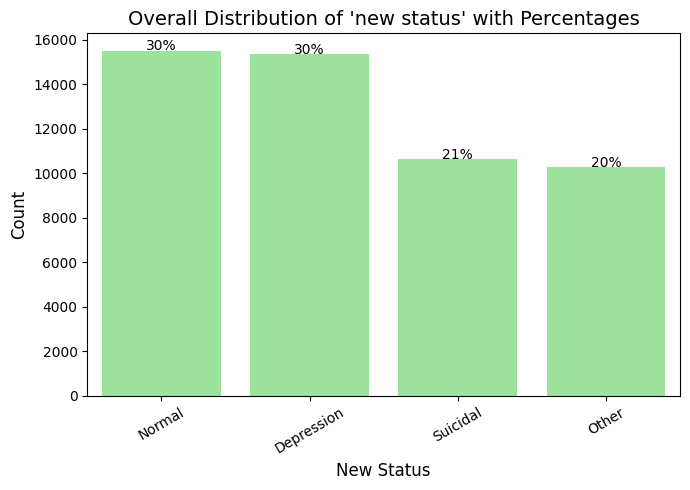

In [47]:
# calculate the overall distribution of status and percentages
status_distribution_overall = df['grouped_status'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of 'new status':")
print(status_distribution_overall)
print("\nPercentages of 'new status':")
print(status_percentages.round())

# plot the overall status distribution with percentages
plt.figure(figsize=(7, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='lightgreen')

# titles and labels
plt.title("Overall Distribution of 'new status' with Percentages", fontsize=14)
plt.xlabel("New Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()

---
# Step 7: Exploratory Data Analysis (After New Class Grouping)
### Most Common Bi-Grams per New Status Class Grouping

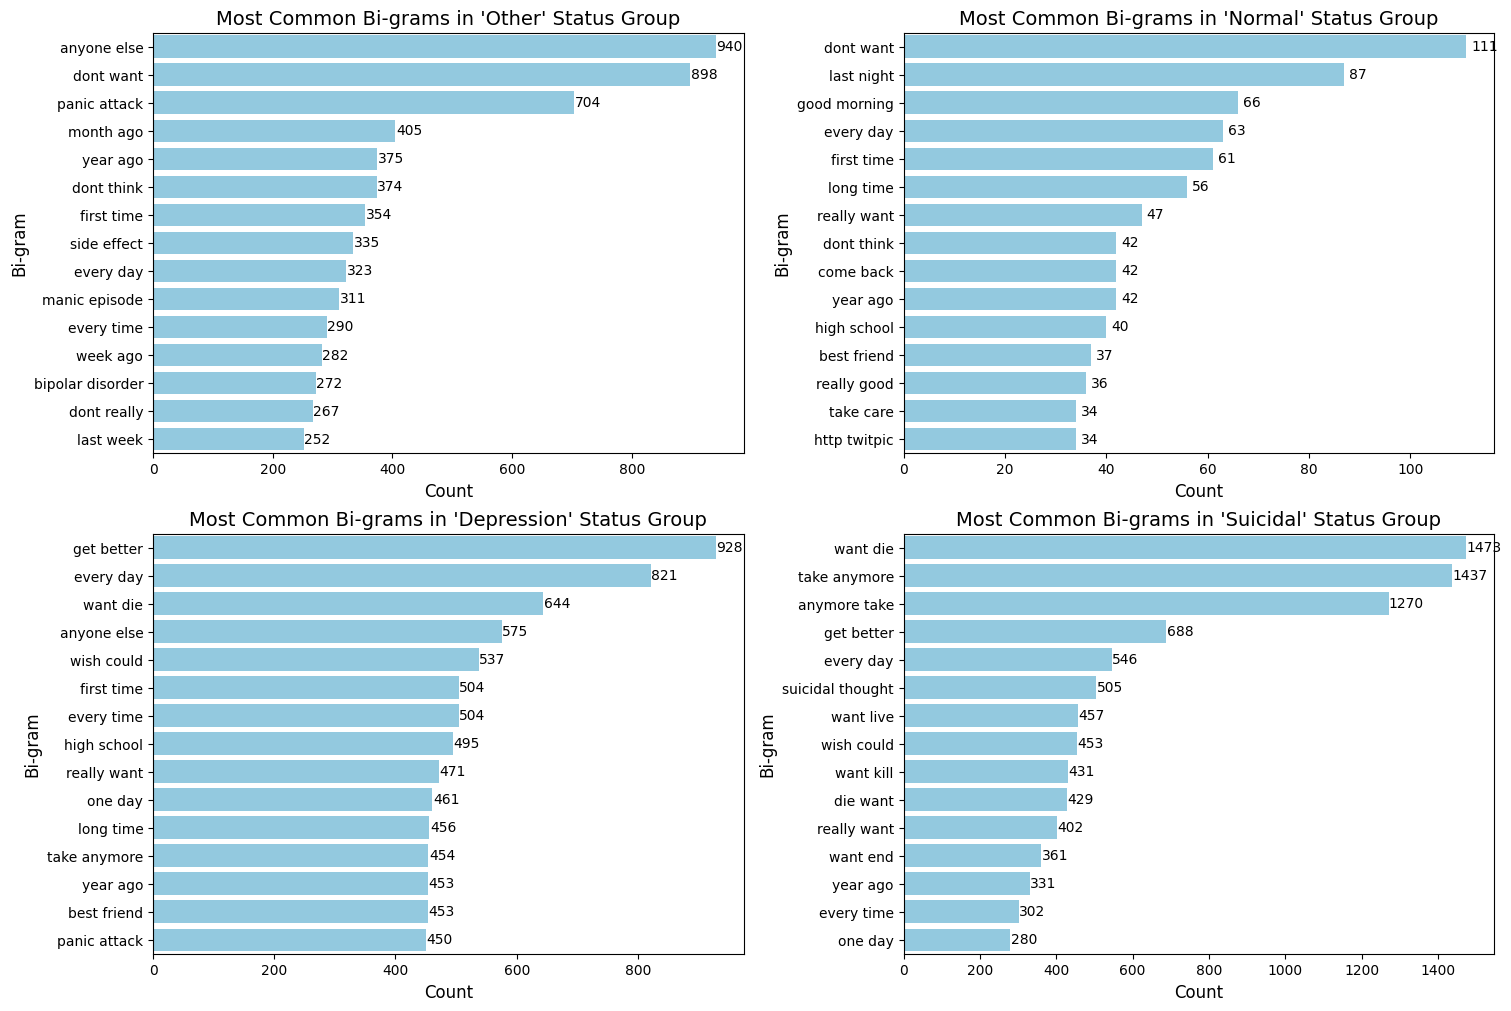

In [48]:
# Function to get most common bi-grams for a given status group
def get_common_bigrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['grouped_status'] == status]['processed_text']
    # Flatten tokens and generate bi-grams
    bigram_list = [bigram for text in filtered_text for bigram in bigrams(text)]
    # Get most common bi-grams
    return Counter(bigram_list).most_common(n)

status_categories = df['grouped_status'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common bi-grams for the current status
    most_common_bigrams = get_common_bigrams(df, status, n=15)
    # Convert bi-grams to a readable format (e.g., "word1 word2")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2}", count) for (w1, w2), count in most_common_bigrams],
        columns=['Bi-gram', 'Count']
    )

    # Plot the most common bi-grams
    sns.barplot(data=most_common_df, x='Count', y='Bi-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common Bi-grams in '{status}' Status Group", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("Bi-gram", fontsize=12)

    # Add the count on the bars
    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )
for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

### Most Common N-Gram per New Status Class Grouping

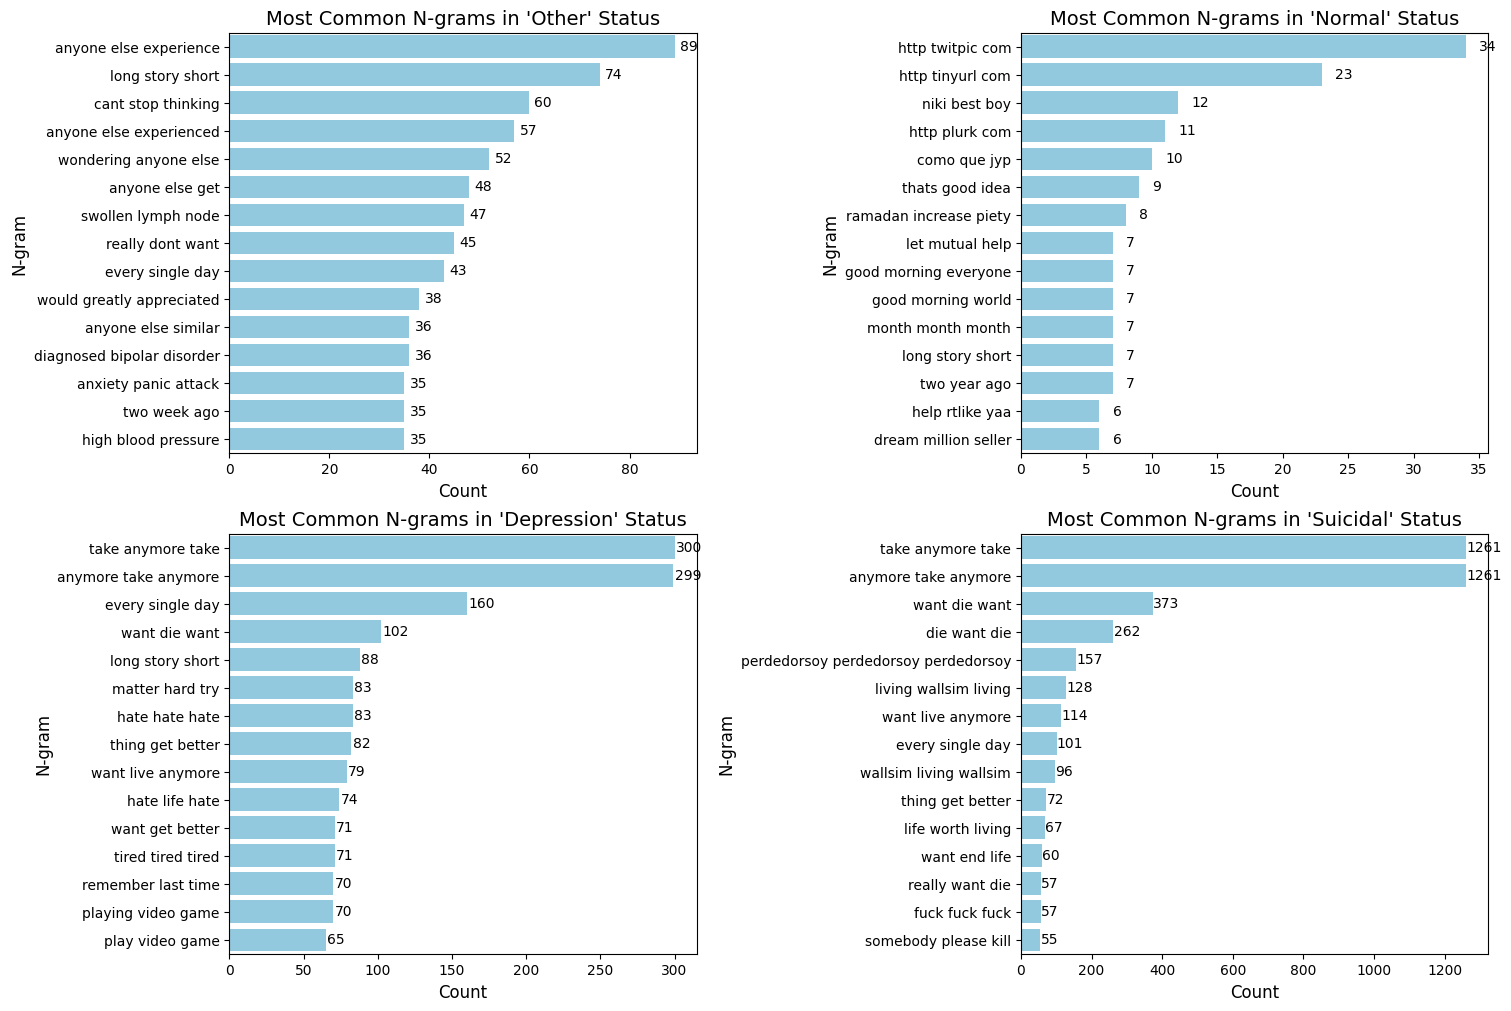

In [49]:
# Helper function to remove duplicates while preserving token order

# Function to get most common N-grams for a given status
def get_common_ngrams(df, status, n=15):
    # Filter for specific status and extract tokens
    filtered_text = df[df['grouped_status'] == status]['processed_text']

    # Generate N-grams from cleaned, unique tokens
    ngram_list = [ngram for text in filtered_text for ngram in ngrams(text, 3)]

    # Get most common N-grams
    return Counter(ngram_list).most_common(n)


status_categories = df['grouped_status'].unique()
num_status = len(status_categories)
cols = 2
rows = (num_status + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)


axes = axes.flatten()

# Iterate over status categories
for idx, status in enumerate(status_categories):
    # Get most common N-grams for the current status
    most_common_ngrams = get_common_ngrams(df, status, n=15)
    # Convert N-grams to a readable format (e.g., "word1 word2 word3")
    most_common_df = pd.DataFrame(
        [(f"{w1} {w2} {w3}", count) for (w1, w2, w3), count in most_common_ngrams],
        columns=['N-gram', 'Count']
    )

    # Plot the most common N-grams
    sns.barplot(data=most_common_df, x='Count', y='N-gram', color='skyblue', ax=axes[idx])
    axes[idx].set_title(f"Most Common N-grams in '{status}' Status", fontsize=14)
    axes[idx].set_xlabel("Count", fontsize=12)
    axes[idx].set_ylabel("N-gram", fontsize=12)

    for bar, count in zip(axes[idx].patches, most_common_df['Count']):
        axes[idx].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{count}",
            va='center', fontsize=10
        )

for idx in range(len(status_categories), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

---
# Step 8: Split the Data

In [50]:
# Define features and labels
X = df['processed_text']
X = X.apply(lambda tokens: " ".join(tokens))
y = df['grouped_status']

In [51]:
# define function to split into train, val, and test sets
def train_val_test_split(X, y, val_size, test_size, random_state):
  # split into train and val_test
	X_train, X_val_test, y_train, y_val_test = train_test_split(
		X,
		y,
    test_size = val_size + test_size,
    random_state = random_state,
    stratify = y
	)

	# split into val and test
	X_val, X_test, y_val, y_test = train_test_split(
		X_val_test,
		y_val_test,
    test_size = test_size / (val_size + test_size),
    random_state = random_state,
    stratify = y_val_test
	)

	return X_train, X_val, X_test, y_train, y_val, y_test

# split into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
	X,
	y,
	val_size = 0.2,
	test_size = 0.2,
	random_state = 42
)

# get shape of each dataframe
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_val:", y_val.shape)
print("Shape of Y_test:", y_test.shape)

Shape of X_train: (31077,)
Shape of X_val: (10359,)
Shape of X_test: (10359,)
Shape of Y_train: (31077,)
Shape of Y_val: (10359,)
Shape of Y_test: (10359,)


In [52]:
# encode the classes into integers. Sparse form.
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

---
# Step 9: Baseline Bag-of-Words Model

In [56]:
# define baseline model architecture with hyperparameter tuning support
def build_bow_model_tuner(hp):
  # define vocab_size
  vocab_size = 10000

  # initialize the Sequential model
  model = tf.keras.Sequential()

  # add the text vectorization layer
  model.add(vectorize_layer)

  # add Dense layer
  model.add(tf.keras.layers.Dense(
      units = 4,
      activation = 'softmax'
  ))

  # tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

  # configure the model
  model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics = ['accuracy']
    )

  return model

In [57]:
# define path to the saved model
file_name = 'models/baseline_model.h5'
file_path = f"{folder_path}/{file_name}"

if os.path.exists(file_path):  # load the baseline model if the file exists
  # load baseline model
  baseline_model = load_model(file_path)

else:  # train a new baseline model if the model's file does not exist
  # clear session and set random seed
  shutil.rmtree('./untitled_project', ignore_errors=True)
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # define the TextVectorization layer
  vocab_size = 10000  # define vocab_size
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab_size,
      output_mode = 'binary',
  )
  vectorize_layer.adapt(X_train)  # adapt the layer to the training data

  # define max number of epochs for tuning
  max_epoch_val = 10

  # define early stopping
  stop_early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_accuracy',
      patience = 3
  )

  # define tuner for hyperparameter tuning
  tuner = kt.Hyperband(
      build_bow_model_tuner,
      objective = 'val_accuracy',
      max_epochs = max_epoch_val
  )

  # perform hyperparameter tuning
  tuner.search(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

  # best learning rate
  print("Best Learning Rate:", best_hps.get('learning_rate'))

  # build and train model with best hyperparameters to find best epoch
  tuned_model = tuner.hypermodel.build(best_hps)
  history = tuned_model.fit(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best epoch
  val_accuracy_per_epoch = history.history['val_accuracy']
  best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
  print("Best epoch: %d" % (best_epoch,))

  # train with best hyperparameters and best epoch to get final baseline model
  baseline_model = tuner.hypermodel.build(best_hps)
  history = baseline_model.fit(
      x = X_train,
      y = y_train,
      epochs = best_epoch,
      validation_data = (X_val, y_val),
      verbose = 1
  )

  # get final accuracies
  training_accuracy = history.history['accuracy'][-1]
  validation_accuracy = history.history['val_accuracy'][-1]
  print('Training Accuracy: %.4f' % training_accuracy)
  print('Validation Accuracy: %.4f' % validation_accuracy)

  # save the baseline model
  baseline_model.save(file_path)

# evaluate on test set
test_loss, test_accuracy = baseline_model.evaluate(
    X_test,
    y_test,
    verbose = 1
)

# get test accuracy of baseline bag-of-words model
print('Test Accuracy: %.4f' % test_accuracy)

Trial 3 Complete [00h 04m 44s]
val_accuracy: 0.7200502157211304

Best val_accuracy So Far: 0.7200502157211304
Total elapsed time: 00h 15m 30s
Best Learning Rate: 0.01
Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 130s 133ms/step - accuracy: 0.6753 - loss: 1691390831635726336.0000 - val_accuracy: 0.7189 - val_loss: 4439945875581566976.0000
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 152s 143ms/step - accuracy: 0.7704 - loss: 1594381470472863744.0000 - val_accuracy: 0.7205 - val_loss: 3525369354818420736.0000
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 128s 129ms/step - accuracy: 0.7843 - loss: 1679704672299909120.0000 - val_accuracy: 0.6922 - val_loss: 5846020311757094912.0000
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 125s 129ms/step - accuracy: 0.7388 - loss: 1854810282799398912.0000 - val_accuracy: 0.7302 - val_loss: 1103865212785655808.0000
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 157s 145ms/step - accuracy: 0.8102 - loss: 1960616836496097280.0000 - val_accuracy: 0.6980 - val_loss: 346716643192419123

Training Accuracy: 0.7292
Validation Accuracy: 0.7305
324/324 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.7259 - loss: 1157462075312701440.0000
Test Accuracy: 0.7254


#### The baseline model is a **logistic regression binary representation (one-hot) bag-of-words model** created using TensorFlow and Keras. The best hyperparameters found are a **Learning Rate of 0.01** and a **Number of Epochs of 4**.
####***This Baseline model has a test accuracy of 0.7266.***

---

# Step 10: Bag-of-Embeddings Model

In [58]:
# define bag-of-embeddings model architecture with hyperparameter tuning support
def build_boe_model_tuner(hp):
  # define hyperparameters to tune
  hp_embedding_dim = hp.Choice('embedding_dim', values=[128, 200])
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

  # define vocab_size
  vocab_size = 10000

  # initialize the Sequential model
  model = tf.keras.Sequential()

  # add the text vectorization layer
  model.add(vectorize_layer)

  # add embedding layer
  model.add(tf.keras.layers.Embedding(
      input_dim = vocab_size,
      output_dim = hp_embedding_dim,
      input_length = None
  ))

  # Add pooling layer
  model.add(tf.keras.layers.GlobalAveragePooling1D())

  # add Dense layer
  model.add(tf.keras.layers.Dense(
      units = 4,
      activation = 'softmax'
  ))

  # configure the model
  model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics = ['accuracy']
    )

  return model

In [59]:
# define path to the saved model
file_name = 'models/bagofembeddings_model.h5'
file_path = f"{folder_path}/{file_name}"

if os.path.exists(file_path):  # load the boe model if the file exists
  # load boe model
  bagofembeddings_model = load_model(file_path)

else:  # train a new boe model if the model's file does not exist
  # clear session and set random seed
  shutil.rmtree('./untitled_project', ignore_errors=True)
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # define the TextVectorization layer
  vocab_size = 10000  # define vocab_size
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab_size,
      output_mode = 'int',
      output_sequence_length = 150
  )
  vectorize_layer.adapt(X_train)  # adapt the layer to the training data

  # define max number of epochs for tuning
  max_epoch_val = 10

  # define early stopping
  stop_early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_accuracy',
      patience = 3
  )

  # define tuner for hyperparameter tuning
  tuner = kt.Hyperband(
      build_boe_model_tuner,
      objective = 'val_accuracy',
      max_epochs = max_epoch_val
  )

  # perform hyperparemter search
  tuner.search(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

  # best learning rate and embedding dimensions
  print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
  print(f"Best Embedding Dimension: {best_hps.get('embedding_dim')}")

  # build and train model with optimal hyperparameters to find best epoch
  tuned_model = tuner.hypermodel.build(best_hps)
  history = tuned_model.fit(
      x = X_train,
      y = y_train,
      epochs = max_epoch_val,
      validation_data = (X_val, y_val),
      callbacks = [stop_early],
      verbose = 1
  )

  # get best epoch
  val_accuracy_per_epoch = history.history['val_accuracy']
  best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
  print("Best epoch: %d" % (best_epoch,))

  # tune batch size with the best hyperparameters and best epoch
  # define batch sizes to try
  batch_sizes = [16, 32]
  best_batch_size = None
  best_val_accuracy = 0

  # go through each batch size
  for batch_size in batch_sizes:
      print(f"Testing batch size: {batch_size}")
      model = tuner.hypermodel.build(best_hps)
      history = model.fit(
          x=X_train,
          y=y_train,
          epochs=best_epoch,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          verbose=1
      )
      val_accuracy = history.history['val_accuracy'][-1]
      print(f"Validation Accuracy with batch size {batch_size}: {val_accuracy:.4f}")

      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          best_batch_size = batch_size

  # get best batch size
  print(f"Best Batch Size: {best_batch_size}")

  # train with best hyperparameters to get final boe model
  bagofembeddings_model = tuner.hypermodel.build(best_hps)
  history = bagofembeddings_model.fit(
      x = X_train,
      y = y_train,
      epochs = best_epoch,
      batch_size = best_batch_size,
      validation_data = (X_val, y_val),
      verbose = 1
  )

  # get final accuracies with all tuned hyperparameters
  training_accuracy = history.history['accuracy'][-1]
  validation_accuracy = history.history['val_accuracy'][-1]
  print('Training Accuracy: %.4f' % training_accuracy)
  print('Validation Accuracy: %.4f' % validation_accuracy)

  # save the baseline model
  bagofembeddings_model.save(file_path)

# evaluate on test set
test_loss, test_accuracy = bagofembeddings_model.evaluate(
    X_test,
    y_test,
    verbose = 1
)

# get test accuracy of bag-of-words model
print('Test Accuracy: %.4f' % test_accuracy)

Trial 6 Complete [00h 01m 10s]
val_accuracy: 0.49773144721984863

Best val_accuracy So Far: 0.7186987400054932
Total elapsed time: 00h 05m 58s
Best Learning Rate: 0.001
Best Embedding Dimension: 200
Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.4986 - loss: 1.1376 - val_accuracy: 0.6674 - val_loss: 0.7924
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6920 - loss: 0.7568 - val_accuracy: 0.7195 - val_loss: 0.7032
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.7404 - loss: 0.6565 - val_accuracy: 0.7385 - val_loss: 0.6656
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.7677 - loss: 0.5966 - val_accuracy: 0.7451 - val_loss: 0.6457
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.7857 - loss: 0.5528 - val_accuracy: 0.7499 - val_loss: 0.6378
Epoch 6/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.8006 - loss: 0.5182 - val_accuracy: 0.7528 - val_loss: 0.6361
Epoch 7/10
972/972 ━━

Training Accuracy: 0.8306
Validation Accuracy: 0.7597
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7482 - loss: 0.6728
Test Accuracy: 0.7534


####***The tuned Bag-of-Embeddings Model has a test accuracy of 0.7554.***